# Import

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, date

# Load Data

In [3]:
customers = pd.read_csv('./data/olist_customers_dataset.csv.zip')
geolocalisation = pd.read_csv('./data/olist_geolocation_dataset.csv.zip')
order_items = pd.read_csv('./data/olist_order_items_dataset.csv.zip')
payments = pd.read_csv('./data/olist_order_payments_dataset.csv.zip')
reviews = pd.read_csv('./data/olist_order_reviews_dataset.csv.zip')
orders = pd.read_csv('./data/olist_orders_dataset.csv.zip')
products = pd.read_csv('./data/olist_products_dataset.csv.zip')
sellers = pd.read_csv('./data/olist_sellers_dataset.csv')
product_cat = pd.read_csv('./data/product_category_name_translation.csv')

In [4]:
df = orders.merge(
    reviews, on='order_id', how='left').merge(
    payments, on='order_id', how='left').merge(
    order_items, on='order_id', how='left').merge(
    products, on='product_id', how='left').merge(
    sellers, on='seller_id', how='left').merge(
    customers, on='customer_id', how='left').merge(
    product_cat, on='product_category_name', how='left')

# Premiere Exploration

In [5]:
df.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                   177
order_delivered_carrier_date       2086
order_delivered_customer_date      3421
order_estimated_delivery_date         0
review_id                           997
review_score                        997
review_comment_title             105154
review_comment_message            68898
review_creation_date                997
review_answer_timestamp             997
payment_sequential                    3
payment_type                          3
payment_installments                  3
payment_value                         3
order_item_id                       833
product_id                          833
seller_id                           833
shipping_limit_date                 833
price                               833
freight_value                       833
product_category_name              2542


/!\ 
- numero de client = customer_unique_id et non customer_id (numero de client affilié sur la commande !)
- Calcul du prix de la commande : payment value parfois dupliqué sur plusieurs fois le même items
- idem pour le calcul des reviews

In [6]:
df[(~df.review_comment_title.isna()) &
   (df.review_comment_message.isna())][
    ['review_comment_title', 'review_comment_message']
]
# il faudrait récupérer les titres si je travaille sur du nlp

,review_comment_title,review_comment_message
41,10,NaN
95,Bom atendimento,NaN
185,Excelente!!!,NaN
206,Otimo,NaN
210,Nota 10,NaN
...,...,...
118921,lannister é nota 10!,NaN
119041,Ótima,NaN
119051,Ótimo,NaN
119076,10,NaN


In [7]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'product_category_name_english'],
      dtype='object')

pas mal de colonnes semblent concernés les produits ou les vendeurs -> inutiles
table sellers semble inutile pour notre problématique

In [8]:
TO_DROP = [
    'product_name_lenght',
    'product_description_lenght',
    'product_photos_qty',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm',
    'order_estimated_delivery_date',
    'review_answer_timestamp',
    'product_category_name',
    'order_approved_at',
    'order_delivered_carrier_date',
    'shipping_limit_date'
]

In [9]:
df.drop(columns=TO_DROP, inplace=True)
df.order_status.value_counts()
# je garde que si order status est délivré
df = df[df.order_status == 'delivered']

In [10]:
print(len(df.customer_city.value_counts()))
print(len(df.customer_state.value_counts()))

# une etude sur l'état semble plus appropriée
df.drop(columns=['customer_city'], inplace=True)

4085
27


In [11]:
df.order_item_id.value_counts()

1.0     101326
2.0      10146
3.0       2352
4.0        967
5.0        454
6.0        258
7.0         61
8.0         37
9.0         29
10.0        26
11.0        18
12.0        13
13.0         8
14.0         7
15.0         5
16.0         3
17.0         3
18.0         3
19.0         3
20.0         3
21.0         1
Name: order_item_id, dtype: int64

In [12]:
len(df.order_id.unique())

96478

In [13]:
# orderPurchase_timestamp-order_approved
# -> temps que le client met pour faie sa commande ?

<AxesSubplot:xlabel='payment_installments', ylabel='Count'>

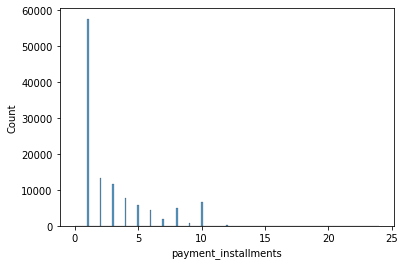

In [41]:
sns.histplot(df.payment_installments)

In [15]:
def date_convertor(serie):
    return pd.to_datetime(serie, format="%Y-%m-%d %H:%M:%S")


to_date = ['review_creation_date',
           'order_delivered_customer_date',
           'order_purchase_timestamp']

for column in to_date:
    df[column] = date_convertor(df[column])

In [16]:
print(df.order_purchase_timestamp.min())
print(df.order_purchase_timestamp.max())

2016-09-15 12:16:38
2018-08-29 15:00:37


In [17]:
pd.to_timedelta(df.review_creation_date.dt.strftime('%S'))

0        0 days
1        0 days
2        0 days
3        0 days
4        0 days
          ...  
119138   0 days
119139   0 days
119140   0 days
119141   0 days
119142   0 days
Name: review_creation_date, Length: 115723, dtype: timedelta64[ns]

In [18]:
df['commentaire_avant_reception'] = 0
df.loc[
    (df['review_creation_date']-df['order_delivered_customer_date']) /
    np.timedelta64(1, 's') < 0,
    'commentaire_avant_reception'] = 1

In [19]:
nombre_commandes = df[['customer_unique_id', 'order_id']].drop_duplicates()
nombre_commandes = nombre_commandes.groupby('customer_unique_id',
                                            as_index=False).count()
nombre_commandes.rename(columns={"order_id": "nb_commandes"}, inplace=True)
df = df.merge(nombre_commandes, on='customer_unique_id')

In [20]:
df[['customer_unique_id',
    'nb_commandes']].drop_duplicates().nb_commandes.value_counts()
# seulement 3% des clients ont plus d'une commande !

1     90557
2      2573
3       181
4        28
5         9
6         5
7         3
15        1
9         1
Name: nb_commandes, dtype: int64

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

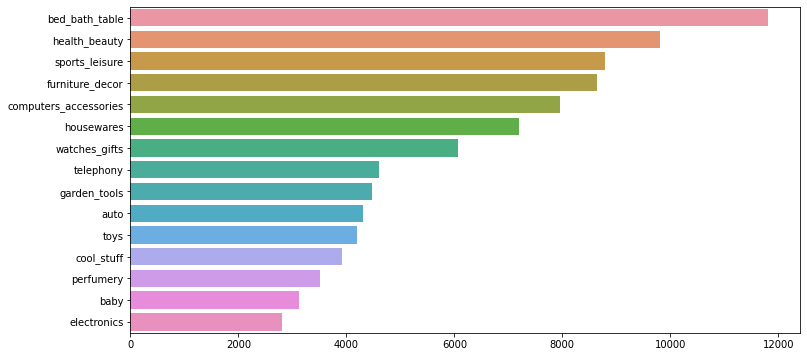

In [21]:
a = df.product_category_name_english.value_counts()
limit = 15
plt.figure(figsize=(12, 6))
sns.barplot(a.values[:limit], y=a.index[:limit])
# sns.countplot(df.product_category_name_english, orient='v')

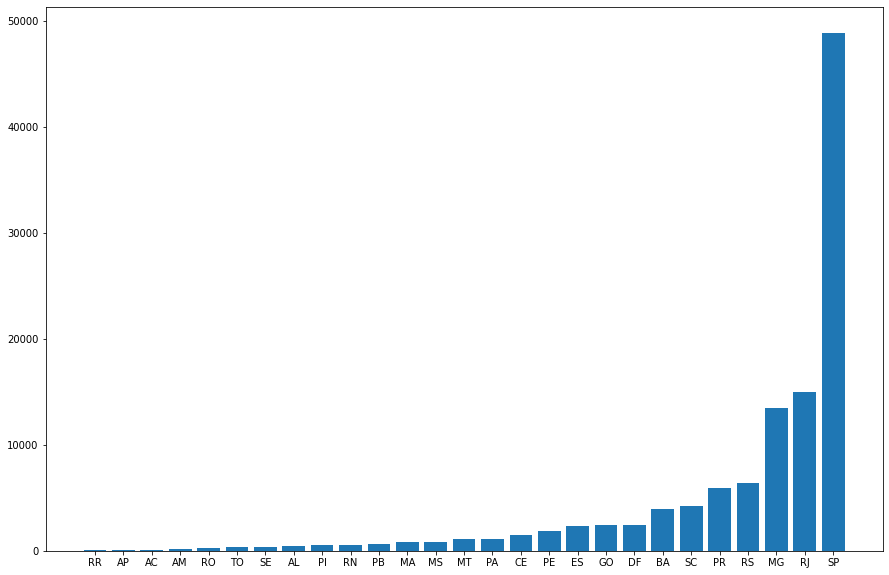

In [40]:
customer_by_state = df[['customer_unique_id',
                        'customer_state']].groupby(
    'customer_state').count().reset_index()
customer_by_state = customer_by_state.sort_values(by=['customer_unique_id'])
plt.figure(figsize=(15, 10))
plt.bar(customer_by_state['customer_state'], customer_by_state[
    'customer_unique_id'])
plt.show()

# Create data frame

In [23]:
FUNCTIONS = {'mean': np.mean,
             'count': np.count_nonzero,
             'sum': sum,
             'list': list,
             'max': max}

TO_DROP = [
    'product_name_lenght',
    'product_description_lenght',
    'product_photos_qty',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm',
    'order_estimated_delivery_date',
    'review_answer_timestamp',
    'product_category_name',
    'order_approved_at',
    'order_delivered_carrier_date',
    'shipping_limit_date'
]

DATE_MAX = date(2018, 12, 31)

TO_DATE = ['review_creation_date',
           'order_delivered_customer_date',
           'order_purchase_timestamp']

In [24]:
TO_OPEN = [
    'olist_customers_dataset',
    'olist_geolocation_dataset',
    'olist_order_items_dataset',
    'olist_order_payments_dataset',
    'olist_order_reviews_dataset',
    'olist_orders_dataset',
    'olist_products_dataset',
]
EXTENSION = '.csv.zip'

In [25]:
class CreateDataset:
    def __init__(self):
        pass

    def go(self, path):
        data = self.read_file(path)
        data['olist_order_items_dataset'] = self.pre_traitement(
            data['olist_order_items_dataset'])
        self.df = self.merging(data)
        return self.df

    def pre_traitement(self, order_items):
        '''create a new columns for total price for an order'''
        orders_value = order_items.groupby('order_id',
                                           as_index=False)[
            ['price', 'freight_value']
        ].sum()
        orders_value['total_order_value'] = orders_value[
                                            'price'] + orders_value[
                                                    'freight_value']
        orders_value = orders_value[
            ['order_id', 'total_order_value']
                                    ].drop_duplicates()
        order_items = order_items.merge(orders_value, on='order_id')
        return order_items

    def read_file(self, path) -> dict:
        data = {}
        for file_name in TO_OPEN:
            path_file = path + file_name+EXTENSION
            data[file_name] = pd.read_csv(path_file)
        return data

    def merging(self, data: dict):
        '''create data from all the datasets
        filter on order_status == delivered '''
        self.df = data['olist_orders_dataset'].merge(
                        data['olist_order_reviews_dataset'],
                        on='order_id',
                        how='left').merge(
                        data['olist_order_payments_dataset'],
                        on='order_id',
                        how='left').merge(
                        data['olist_order_items_dataset'],
                        on='order_id',
                        how='left').merge(
                        data['olist_products_dataset'],
                        on='product_id',
                        how='left').merge(
                        data['olist_customers_dataset'],
                        on='customer_id',
                        how='left')
        self.df = self.df[self.df.order_status == 'delivered']
        return self.df.drop_duplicates()

In [26]:
class CleaningDataset:
    def __init__(self, df):
        self.df = df

    def drop_(self, to_drop: list) -> pd.core.frame.DataFrame:
        '''take a list of columns and return data without those'''
        return self.df.drop(columns=TO_DROP, inplace=True)

    def date_convertor(self,
                       serie:pd.core.series.Series) -> pd.core.series.Series:
        '''take a pandas serie and return it in format datetime'''
        return pd.to_datetime(serie, format="%Y-%m-%d %H:%M:%S")

    def converting_date(self, to_convert_date:list) -> pd.core.frame.DataFrame:
        '''take a list of columns and return them in format datetime'''
        for column in to_convert_date:
            self.df[column] = date_convertor(self.df[column])
        return self.df

    def get_max(row):
        '''return the payment type with the max payment value'''
        if len(row.payment_type) == 1:
            return row.payment_type[0]
        else:
            row.payment_type = sorted(row.payment_type, key=lambda y: order[y])
            index_value_max = row.payment_value.index(max(row.payment_value))
        return row.payment_type[index_value_max]

    def groupby_merging(self,
                        columns_selection: list,
                        col_to_groupby: str,
                        col_to_aggregate: str,
                        new_col_name: str,
                        function: str,
                        drop=True) -> pd.core.frame.DataFrame:
        '''
        groupby, aggregate and merge new feature with:
        - column 1 = col to groupby,
        - column 2 = col to apply a function on
        - new_col_name = nom de la nouvelle colonne
        - fonction to apply
        - drop = bool  for dropping duolicates or not
        '''
        new_feature = self.df[columns_selection]
        if drop:
            new_feature.drop_duplicates(inplace=True)
        new_feature = new_feature.groupby(col_to_groupby,
                                          as_index=False).agg(
                                            FUNCTIONS[function])
        new_feature.rename(columns={col_to_aggregate: new_col_name},
                           inplace=True)
        new_feature = new_feature[['customer_unique_id', new_col_name]]
        self.df = self.df.merge(new_feature,
                                on='customer_unique_id',
                                how='left')
        return self.df

    def scorer_payment_sequential(self) -> pd.core.frame.DataFrame:
        self.df.loc[(self.df['average_payment_seq'] > 0)
                    & (self.df['average_payment_seq'] <= 0.5),
                    'payment_sequential'] = 0.25
        self.df.loc[(self.df['average_payment_seq'] > 0.5) &
                    (self.df['average_payment_seq'] < 1),
                    'payment_sequential'] = 0.75
        return self.df

    def com_before_reception(self) -> pd.core.frame.DataFrame:
        '''
        Create a new col review before order reception: 1 if true, 0 if false
        '''
        self.df['review_before_reception'] = 0
        self.df.loc[
            (self.df['review_creation_date'] - self.df[
                        'order_delivered_customer_date']) /
            np.timedelta64(1, 's') < 0, 'review_before_reception'] = 1
        columns_selection = ['customer_unique_id', 'review_before_reception']
        self.df = self.groupby_merging(columns_selection,
                                       'customer_unique_id',
                                       'review_before_reception',
                                       'mean_review_before_reception',
                                       'mean',
                                       drop=False)
        self.df['review_before_reception'] = self.df[
            'mean_review_before_reception'].apply(
                                            lambda x: 1 if x >= 0.5 else 0)
        return self.df

    def number_commandes(self) -> pd.core.frame.DataFrame:
        '''
        add a new feature: 'number_of_orders'
        count how many orders each customer did
        '''
        columns_selection = ['customer_unique_id',
                             'order_id']
        self.df = self.groupby_merging(columns_selection,
                                       'customer_unique_id',
                                       'order_id',
                                       'number_of_orders',
                                       'count')
        return self.df

    def mean_review(self) -> pd.core.frame.DataFrame:
        '''
        add a new feature: "mean_review_score"
        mean review score for each customer
        '''
        columns_selection = ['customer_unique_id',
                             'order_id',
                             'review_score']
        self.df = self.groupby_merging(columns_selection,
                                       ['customer_unique_id', 'order_id'],
                                       'review_score',
                                       'mean_review_score',
                                       'mean',
                                       drop=True)
        return self.df

    def average_order_price(self) -> pd.core.frame.DataFrame:
        '''
        add a a feature: "mean_orders_price"
        average spend for each customer
        '''
        columns_selection = ['customer_unique_id',
                             'order_id',
                             'total_order_value']
        self.df = self.groupby_merging(columns_selection,
                                       'customer_unique_id',
                                       'total_order_value',
                                       'mean_order_price',
                                       'mean',
                                       drop=True)
        return self.df

    def cum_sum_order_price(self) -> pd.core.frame.DataFrame:
        '''
        add a a feature: "cum_sum_order"
        cumulative spend for a customer
        '''
        columns_selection = ['customer_unique_id',
                             'order_id',
                             'total_order_value']
        self.df = self.groupby_merging(columns_selection,
                                       'customer_unique_id',
                                       'total_order_value',
                                       'cum_sum_order',
                                       'sum',
                                       drop=True)
        return self.df

    def review_title(self) -> pd.core.frame.DataFrame:
        '''
        modify feature: 'review_comment_message'
        add the title to the 'review_comment_message'
        '''
        self.df[['review_comment_title',
                 'review_comment_message']] = self.df[
            ['review_comment_title',
             'review_comment_message']].fillna('')
        self.df['review_comment_message'] = self.df[
                        'review_comment_message'] + self.df[
                                        'review_comment_title']
        self.df['review_comment_message'] = self.df[
                                                    'review_comment_message'
                                                    ].replace('', np.nan)
        return self.df

    def last_visit(self):
        '''
        add a feature: last_visit
        indicate how many days from DATE_MAX to the last order
        '''
        self.df['timedelta'] = (pd.to_datetime(DATE_MAX) -
                                self.df[
                                    'order_purchase_timestamp'
                                        ]) / np.timedelta64(1, 'D')
        columns_selection = ['customer_unique_id', 'timedelta']
        self.df = self.groupby_merging(columns_selection,
                                       'customer_unique_id',
                                       'timedelta',
                                       'recently_order',
                                       'max')
        return self.df.drop(columns=['timedelta'], inplace=True)

    def payment_type_pref(self):
        '''
        add a feature: payment_type_pref
        '''
        df_ = self.df[['customer_unique_id',
                       'payment_value',
                       'payment_type',
                       'payment_installments']].drop_duplicates()
        df_ = df_.groupby(['customer_unique_id', 'payment_type'],
                          as_index=False).sum()
        df_ = df_[['customer_unique_id',
                   'payment_value',
                   'payment_type']].groupby('customer_unique_id',
                                            as_index=False).agg(list)
        df_['payment_pref'] = df_.apply(lambda x: get_max(x), axis=1)
        df_ = df_[['customer_unique_id', 'payment_pref']]
        self.df = self.df.merge(df_, on='customer_unique_id', how='left')
        return self.df

    def normalisation(self, features_to_normalized, default=False):
        '''if set to true, normalised data'''
        if default:
            for feature in features_to_normalized:
                scaler = StandardScaler()
                self.df[feature] = scaler.fit_transform(self.df[[feature]])
        return self.df

    def encoding_frequency(self, features_to_encode):
        '''encode by frequency some features'''
        for feature in features_to_encode:
            new_col_name = feature + '_encode'
            selection = self.df[['customer_unique_id', feature]]
            to_encode = {item[0]: item[1] for
                         item in selection[feature].value_counts().iteritems()}
            selection[feature] = selection[
                feature].apply(
                lambda x: to_encode[x] / sum(to_encode.values()))
            selection.rename(columns={feature: new_col_name}, inplace=True)
            selection.drop_duplicates(inplace=True)
            self.df = self.df.merge(selection, on='customer_unique_id')
        return self.df

    def remove_outliers(self, defautl=False):
        '''remove outliers for mean_order_price
        and recently_order
        '''
        quantile = self.df.mean_order_price.quantile(0.99)
        self.df = self.df[self.df.mean_order_price < quantile]
        self.df = self.df[self.df.recently_order < 800]
        return self.df

    def final_cleaning(self):
        '''
        drop columns without a real interest
        drop duplicates: return a dataset with a row for one client
        '''
        no_interest = [
            'order_id', 'customer_id', 'order_status',
            'order_purchase_timestamp', 'review_id', 'review_score',
            'review_comment_title', 'review_creation_date',
            'payment_sequential', 'payment_type', 'order_item_id',
            'product_id', 'seller_id', 'price', 'freight_value',
            'customer_zip_code_prefix', 'customer_city',
            'review_before_reception', 'mean_review_before_reception',
            'total_order_value']
        self.df.drop(columns=no_interest, inplace=True)
        self.df.drop_duplicates(inplace=True)
        return self.df



29: E231 missing whitespace after ':'
46: E231 missing whitespace after ':'


In [27]:
def main():
    data = CreateDataset().go('./data/')
    data = CleaningDataset(data)
    data.drop_(TO_DROP)
    data.converting_date(TO_DATE)
    data.com_before_reception()
    data.review_title()
    data.number_commandes()
    data.mean_review()
    data.average_order_price()
    data.cum_sum_order_price()
    data.last_visit()
    data.normalisation(['mean_order_price',
                        'cum_sum_order',
                        'order_number',
                        'mean_review_score',
                       'recently_order'],
                       False)
    data.encoding_frequency(['customer_state'])
    data.final_cleaning()
    return data

In [28]:
data = main()
data.df

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,order_delivered_customer_date,review_comment_message,payment_installments,payment_value,customer_unique_id,customer_state,number_of_orders,mean_review_score,mean_order_price,cum_sum_order,recently_order,customer_state_encode
0,2017-10-10 21:25:13,"Não testei o produto ainda, mas ele veio corre...",1.0,18.12,7c396fd4830fd04220f754e42b4e5bff,SP,2,5.0,41.41,82.82,482.523171,0.423539
1,2017-10-10 21:25:13,"Não testei o produto ainda, mas ele veio corre...",1.0,18.12,7c396fd4830fd04220f754e42b4e5bff,SP,2,4.0,41.41,82.82,482.523171,0.423539
2,2017-10-10 21:25:13,"Não testei o produto ainda, mas ele veio corre...",1.0,2.00,7c396fd4830fd04220f754e42b4e5bff,SP,2,5.0,41.41,82.82,482.523171,0.423539
3,2017-10-10 21:25:13,"Não testei o produto ainda, mas ele veio corre...",1.0,2.00,7c396fd4830fd04220f754e42b4e5bff,SP,2,4.0,41.41,82.82,482.523171,0.423539
4,2017-10-10 21:25:13,"Não testei o produto ainda, mas ele veio corre...",1.0,18.59,7c396fd4830fd04220f754e42b4e5bff,SP,2,5.0,41.41,82.82,482.523171,0.423539
...,...,...,...,...,...,...,...,...,...,...,...,...
126123,2017-03-17 15:08:01,NaN,3.0,85.08,6359f309b166b0196dbf7ad2ac62bb5a,SP,1,5.0,85.08,85.08,661.587442,0.423539
126124,2018-02-28 17:37:56,So uma peça que veio rachado mas tudo bem rs,3.0,195.00,da62f9e57a76d978d02ab5362c509660,SP,1,4.0,195.00,195.00,327.459051,0.423539
126125,2017-09-21 11:24:17,Foi entregue antes do prazo.,5.0,271.01,737520a9aad80b3fbbdad19b66b37b30,BA,1,5.0,271.01,271.01,490.384225,0.033932
126126,2018-01-25 23:32:54,Foi entregue somente 1. Quero saber do outro p...,4.0,441.16,5097a5312c8b157bb7be58ae360ef43c,RJ,1,2.0,441.16,441.16,356.105243,0.129691


In [29]:
# verification que je ne perdre pas de client en cours de route !
len(df[
    df.order_status == 'delivered'
]['customer_unique_id'].unique()) == len(data.df.customer_unique_id.unique())

True

# Data analysis 2

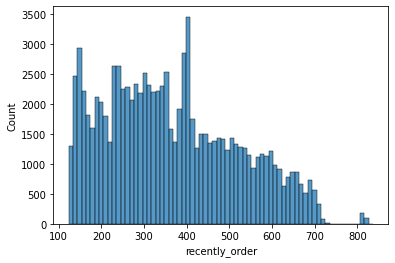

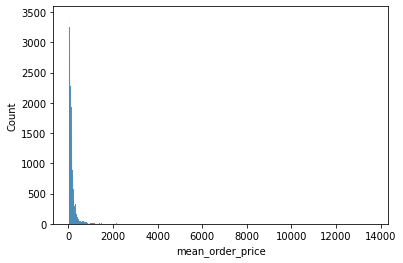

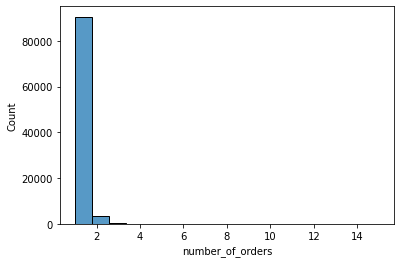

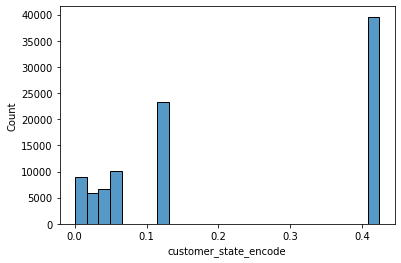

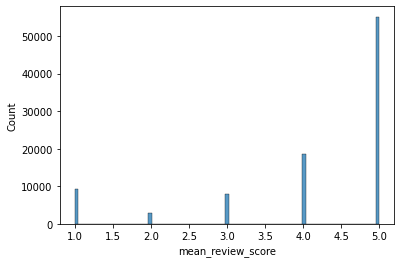

In [30]:
df_data_analysis = data.df[['customer_unique_id',
                            'recently_order',
                            'mean_order_price',
                            'number_of_orders',
                            'customer_state_encode',
                            'mean_review_score']].drop_duplicates()
for col in ['recently_order',
            'mean_order_price',
            'number_of_orders',
            'customer_state_encode',
            'mean_review_score']:
    a = sns.histplot(df_data_analysis[col])
    plt.show(a)

Il semble y avoir des données abérantes :
- sur la recency : quelques données sont séparés -> à supprimer
- la colonnes mean_order_price (monetary) semble écraser : supprimer la/les valeurs dans le 99% percentiles
--> focntion remove outliers dans class


In [31]:
data.remove_outliers(True)

,order_delivered_customer_date,review_comment_message,payment_installments,payment_value,customer_unique_id,customer_state,number_of_orders,mean_review_score,mean_order_price,cum_sum_order,recently_order,customer_state_encode
0,2017-10-10 21:25:13,"Não testei o produto ainda, mas ele veio corre...",1.0,18.12,7c396fd4830fd04220f754e42b4e5bff,SP,2,5.0,41.41,82.82,482.523171,0.423539
1,2017-10-10 21:25:13,"Não testei o produto ainda, mas ele veio corre...",1.0,18.12,7c396fd4830fd04220f754e42b4e5bff,SP,2,4.0,41.41,82.82,482.523171,0.423539
2,2017-10-10 21:25:13,"Não testei o produto ainda, mas ele veio corre...",1.0,2.00,7c396fd4830fd04220f754e42b4e5bff,SP,2,5.0,41.41,82.82,482.523171,0.423539
3,2017-10-10 21:25:13,"Não testei o produto ainda, mas ele veio corre...",1.0,2.00,7c396fd4830fd04220f754e42b4e5bff,SP,2,4.0,41.41,82.82,482.523171,0.423539
4,2017-10-10 21:25:13,"Não testei o produto ainda, mas ele veio corre...",1.0,18.59,7c396fd4830fd04220f754e42b4e5bff,SP,2,5.0,41.41,82.82,482.523171,0.423539
...,...,...,...,...,...,...,...,...,...,...,...,...
126123,2017-03-17 15:08:01,NaN,3.0,85.08,6359f309b166b0196dbf7ad2ac62bb5a,SP,1,5.0,85.08,85.08,661.587442,0.423539
126124,2018-02-28 17:37:56,So uma peça que veio rachado mas tudo bem rs,3.0,195.00,da62f9e57a76d978d02ab5362c509660,SP,1,4.0,195.00,195.00,327.459051,0.423539
126125,2017-09-21 11:24:17,Foi entregue antes do prazo.,5.0,271.01,737520a9aad80b3fbbdad19b66b37b30,BA,1,5.0,271.01,271.01,490.384225,0.033932
126126,2018-01-25 23:32:54,Foi entregue somente 1. Quero saber do outro p...,4.0,441.16,5097a5312c8b157bb7be58ae360ef43c,RJ,1,2.0,441.16,441.16,356.105243,0.129691


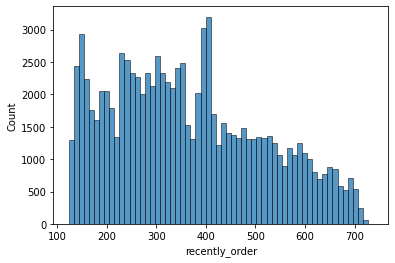

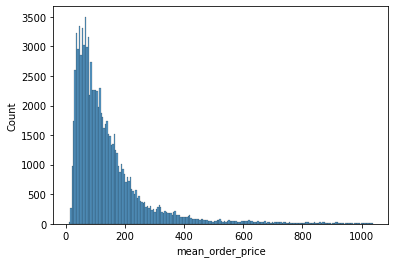

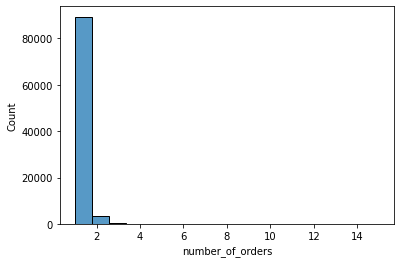

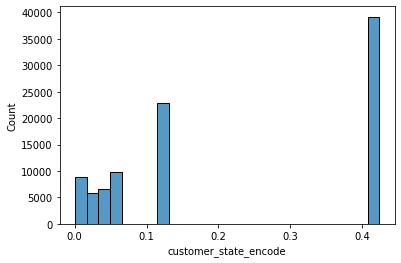

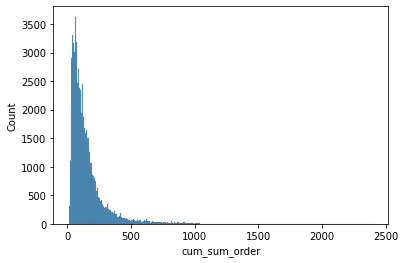

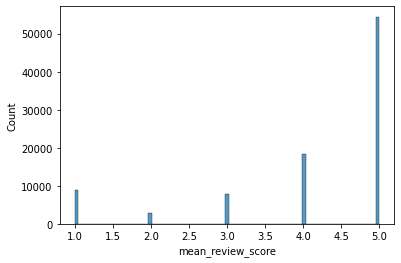

In [32]:
df_data_analysis = data.df[['customer_unique_id',
                            'recently_order',
                            'mean_order_price',
                            'number_of_orders',
                            'cum_sum_order',
                            'customer_state_encode',
                            'mean_review_score']].drop_duplicates()
for col in ['recently_order',
            'mean_order_price',
            'number_of_orders',
            'customer_state_encode',
            'cum_sum_order',
            'mean_review_score']:
    a = sns.histplot(df_data_analysis[col])
    plt.show(a)

In [33]:
df_clean = data.df[['customer_unique_id',
                    'recently_order',
                    'mean_order_price',
                    'cum_sum_order',
                    'number_of_orders',
                    'customer_state_encode',
                   'mean_review_score']].drop_duplicates()

<AxesSubplot:>

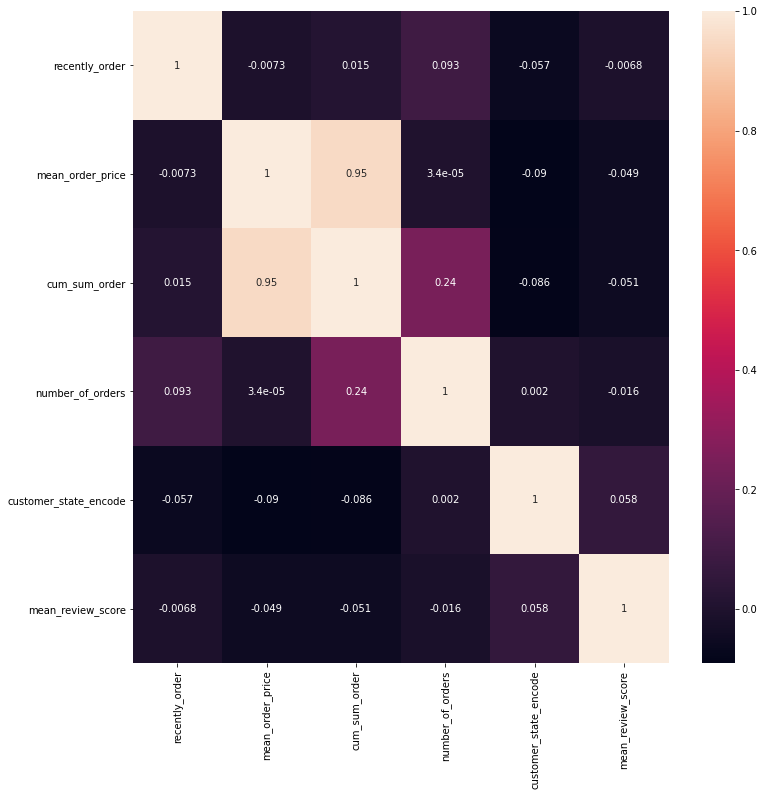

In [34]:
plt.figure(figsize=(12, 12))
sns.heatmap(df_clean.corr(), annot=True)

In [35]:
# cumsum et mean_order_price sont très corrélés, ce qui parait logique vu
# que seul 3% des clients ont fait plus d'une commande
# j'enleve donc mean_order_price
df_clean.drop(columns=['mean_order_price'], inplace=True)

In [36]:
df_clean.to_csv('./df_clean.csv')

In [42]:
data_ari = data.df.copy()
data_ari.drop(columns=['customer_state_encode'], inplace=True)

In [38]:
data_ari.to_csv('./data_ari.csv')